In [17]:
# Importing all necessary libraries
import random
import math
import numpy as np
import pandas as pd

import os
from glob import glob

from tqdm import tqdm
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preparing the dataset

In [3]:
# Getting the path of dataset folder
path_parent = os.path.dirname(os. getcwd())
data_path = path_parent+'\\dataset'

In [4]:
# Specifying image dimensions
IMG_height = 224
IMG_width = 224

In [5]:
# here name of classes == name of dirctories
classes = os.listdir(data_path)

# Counting total number of images for training and valdation
num_images = len(glob(data_path + '/*/*'))
print('Classes : ', classes)
print(f'Number of training images : {num_images}')

Classes :  ['wearing_mask_incorrectly', 'without_mask', 'with_mask']
Number of training images : 6016


In [6]:
# Function to load images from image paths
def parse_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_height, IMG_width])
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [23]:
def augment(image, label):

    image = tfa.image.rotate(image, math.radians(20))
    image = tf.image.adjust_brightness(image, delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)

    # a left upside down flipped is still a person ;)
    image = tf.image.random_flip_left_right(image)  # 50%
    image = tf.clip_by_value(image, 0, 1)

    return image, label

In [24]:
# Collecting all filepath in a directory
filenames = glob(data_path + '/*/*')
# Shuffling the dataset
random.shuffle(filenames)
# Extraction labels from fil paths(as numbers Normal:0, Osteoarthritis:1)
labels = [classes.index(name.split(os.path.sep)[-2]) for name in filenames]

In [25]:
from sklearn.model_selection import train_test_split

(x_train, x_val, y_train, y_val) = train_test_split(filenames, labels,test_size=0.2, stratify=labels, random_state=10)
num_train = len(x_train)
num_val = len(x_val)

In [26]:
def make_dataset(filenames, labels, batch_size, train):
    
    # Creating instance of tf.data.dataset from filenames
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    # loading files
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    images_ds = tf.data.Dataset.zip((images_ds, labels_ds))
    if train:
        images_ds = images_ds.shuffle(buffer_size=100)
        images_ds = images_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    images_ds = images_ds.batch(batch_size)
    images_ds = images_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return images_ds

In [27]:
train_ds = make_dataset(x_train, y_train, batch_size=32, train=True)
val_ds = make_dataset(x_val, y_val, batch_size=32, train=False)

## CNN model training

In [28]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# Freeze base model
baseModel.trainable = False

In [29]:
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [30]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [31]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
rate = 1e-4
ep_no = 20

In [32]:
# Model compilation
optimize = Adam(learning_rate=rate, decay=rate / ep_no)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimize, metrics=["accuracy"])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [34]:
# training model
H = model.fit(train_ds, epochs=ep_no, steps_per_epoch=math.ceil(num_train/32), 
          verbose=1, validation_data=val_ds,
         validation_steps=math.ceil(num_val/32))

Epoch 1/20
151/151 [==============================] - 27s 148ms/step - loss: 0.8085 - accuracy: 0.6407 - val_loss: 0.5857 - val_accuracy: 0.8422
Epoch 2/20
151/151 [==============================] - 21s 138ms/step - loss: 0.4676 - accuracy: 0.8180 - val_loss: 0.5481 - val_accuracy: 0.8164
Epoch 3/20
151/151 [==============================] - 21s 139ms/step - loss: 0.3690 - accuracy: 0.8589 - val_loss: 0.5346 - val_accuracy: 0.8073
Epoch 4/20
151/151 [==============================] - 22s 144ms/step - loss: 0.3297 - accuracy: 0.8755 - val_loss: 0.5028 - val_accuracy: 0.8256
Epoch 5/20
151/151 [==============================] - 22s 144ms/step - loss: 0.2878 - accuracy: 0.8924 - val_loss: 0.4720 - val_accuracy: 0.8422
Epoch 6/20
151/151 [==============================] - 22s 145ms/step - loss: 0.2689 - accuracy: 0.9036 - val_loss: 0.4542 - val_accuracy: 0.8605
Epoch 7/20
151/151 [==============================] - 23s 150ms/step - loss: 0.2445 - accuracy: 0.9133 - val_loss: 0.4352 - val_ac

In [35]:
# predictions on the test set
predIdxs = model.predict(val_ds)
print(predIdxs)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[[9.62377965e-01 9.52546578e-03 2.80966200e-02]
 [4.03202116e-01 9.46993455e-02 5.02098560e-01]
 [9.77816224e-01 1.17301913e-02 1.04536535e-02]
 ...
 [1.30312918e-02 9.85387743e-01 1.58095197e-03]
 [4.77520283e-04 9.99448001e-01 7.45062789e-05]
 [8.70833695e-01 8.17549974e-02 4.74113598e-02]]


In [36]:
# classifocation matrix
cat = ['wearing_mask_incorrectly', 'with_mask', 'without_mask']
pd.DataFrame(classification_report(y_val, predIdxs, target_names=cat, output_dict=True)).T

,precision,recall,f1-score,support
wearing_mask_incorrectly,0.829457,0.782927,0.805521,410.000000
with_mask,0.862700,1.000000,0.926290,377.000000
without_mask,0.852632,0.776978,0.813049,417.000000
accuracy,0.848837,0.848837,0.848837,0.848837
macro avg,0.848263,0.853302,0.848287,1204.000000
weighted avg,0.847893,0.848837,0.845944,1204.000000


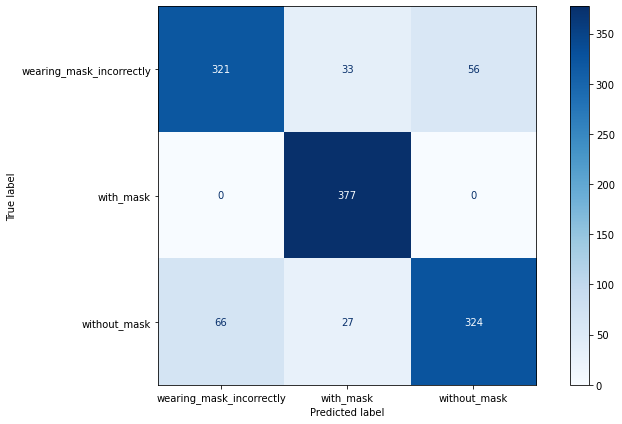

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

conf_mat = confusion_matrix(y_val, predIdxs)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=cat)
disp.plot(cmap='Blues')
plt.tight_layout()
plt.style.use("ggplot")

In [39]:
#save model in disk
model.save("face_mask_detector.model", save_format="h5")

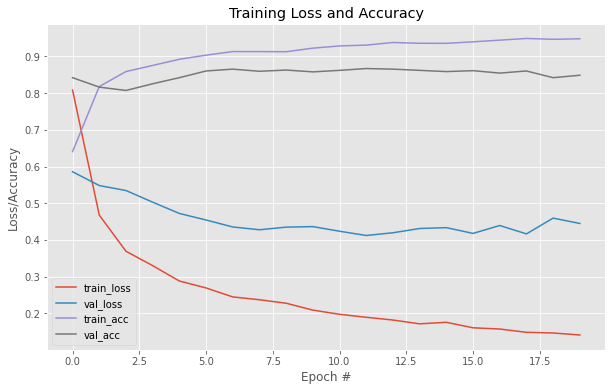

In [40]:
# plot the training loss and accuracy
N = ep_no
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")